# Task 2: Exploratory Data Analysis 

This notebook presents an exploratory data analysis of customer churn data for an energy company. We'll investigate various factors that might influence customer churn and provide insights to guide retention strategies.

## 1. Objectives:
1. Understand the distribution of key variables related to customer churn
2. Explore the relationship between customer tenure and churn probability
3. Investigate correlations between various numeric variables
4. Identify potential factors that might influence a customer's decision to churn

Let's begin by importing necessary libraries and loading our data.

## 2. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from IPython.display import HTML
import base64
from io import BytesIO
from statsmodels.graphics.mosaicplot import mosaic
from collections import defaultdict

from utils import plot_prob_progression
from data_summary import create_summary_table



# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [2]:
import os 

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'  

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
import rpy2.robjects as robjects #interface r objetcs to python
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

d:\DS_Project\BCG_DataScience_VI\.venv\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R 
library(ggplot2)
library(ggstatsplot)
library(dplyr)
library(wesanderson)
library(ggridges)

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



---

## 3. Data Collection and Preprocessing

### 3.1 Data Loading

The analysis uses two main datasets:
1. `client_data.csv`: Contains information about individual customers
2. `price_data.csv`: Includes pricing information

In [69]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')
merged_df = pd.merge(client_df, price_df, on='id')

View the first 3 rows of a dataframe using the `head` method

In [5]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [6]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---

### 3.2 Data Profiling


To get a comprehensive understanding of our dataset, we'll use a custom function `create_summary_table` from the `data_summary` module. This function provides a detailed summary of each variable in our dataset, including statistics, frequency distributions, and visualizations.


#### Client data profile

##### Client Data Profile Summary Table

In [13]:
client_df.shape

(14606, 26)

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],563dde550fd624d7352f3de77c0cdfcd: 1 (0.0%)24011ae4ebbe3035111d65fa7c15bc57: 1 (0.0%)d29c2c54acc38ff3c0614d0a653813dd: 1 (0.0%)764c75f661154dac3a6c254cd082ea7d: 1 (0.0%)bba03439a292a1e166f80264c16191cb: 1 (0.0%),1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%),,0 (0.0%)
2,channel_sales[object],foosdfpfkusacimwkcsosbicdxkicaua: 6754 (46.2%)MISSING: 3725 (25.5%)lmkebamcaaclubfxadlmueccxoimlema: 1843 (12.6%)usilxuppasemubllopkaafesmlibmsdf: 1375 (9.4%)ewpakwlliwisiwduibdlfmalxowmwpci: 893 (6.1%),6754 (46.2%)3725 (25.5%)1843 (12.6%)1375 (9.4%)893 (6.1%),,0 (0.0%)
3,cons_12m[int64],Mean (sd): 159220.3 (573465.3)min < med < max: 0.0 < 14115.5 < 6207104.0IQR (CV): 35089.0 (3.6),11065 distinct values,,0 (0.0%)
4,cons_gas_12m[int64],Mean (sd): 28092.4 (162973.1)min < med < max: 0.0 < 0.0 < 4154590.0IQR (CV): 0.0 (5.8),2112 distinct values,,0 (0.0%)
5,cons_last_month[int64],Mean (sd): 16090.3 (64364.2)min < med < max: 0.0 < 792.5 < 771203.0IQR (CV): 3383.0 (4.0),4751 distinct values,,0 (0.0%)
6,date_activ[object],2009-08-01: 95 (0.7%)2010-02-01: 92 (0.6%)2009-09-01: 76 (0.5%)2009-10-01: 55 (0.4%)2010-01-11: 48 (0.3%),95 (0.7%)92 (0.6%)76 (0.5%)55 (0.4%)48 (0.3%),,0 (0.0%)
7,date_end[object],2016-02-01: 145 (1.0%)2016-08-01: 125 (0.9%)2016-09-01: 117 (0.8%)2016-10-05: 115 (0.8%)2016-12-31: 104 (0.7%),145 (1.0%)125 (0.9%)117 (0.8%)115 (0.8%)104 (0.7%),,0 (0.0%)
8,date_modif_prod[object],2015-11-01: 721 (4.9%)2015-05-24: 269 (1.8%)2015-12-17: 199 (1.4%)2015-09-20: 173 (1.2%)2015-12-16: 172 (1.2%),721 (4.9%)269 (1.8%)199 (1.4%)173 (1.2%)172 (1.2%),,0 (0.0%)
9,date_renewal[object],2015-06-23: 587 (4.0%)2015-03-09: 451 (3.1%)2015-02-09: 273 (1.9%)2015-07-04: 265 (1.8%)2015-10-11: 231 (1.6%),587 (4.0%)451 (3.1%)273 (1.9%)265 (1.8%)231 (1.6%),,0 (0.0%)
10,forecast_cons_12m[float64],Mean (sd): 1868.6 (2387.6)min < med < max: 0.0 < 1112.9 < 82902.8IQR (CV): 1906.8 (1.3),13993 distinct values,,0 (0.0%)

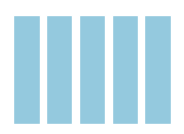
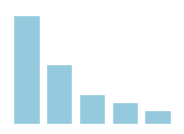
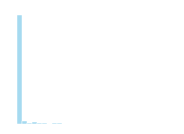
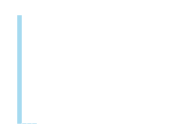
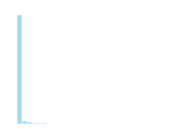
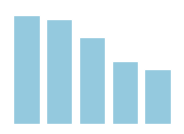
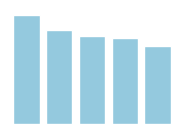
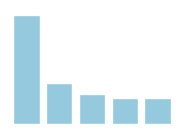
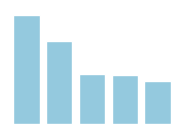
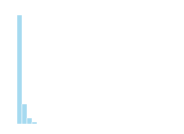
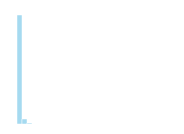
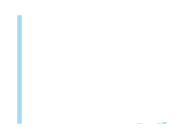
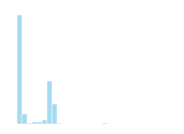
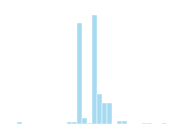
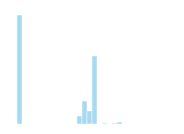
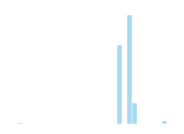
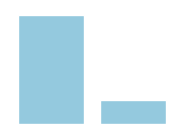
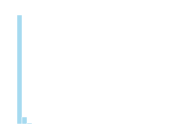
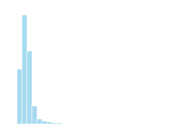
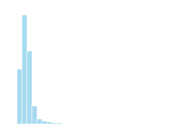
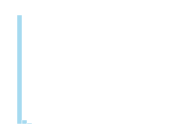
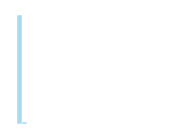
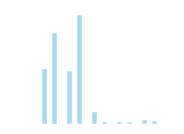
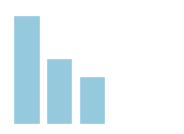
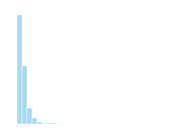
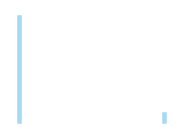

In [5]:
client_df_summary_table = create_summary_table(client_df)
display(client_df_summary_table)

#### Key Observations and Actions from Client Data

1. **Missing Values:**
   - **Observation:** Most variables have no missing data, but `channel_sales` (25.5%) and `origin_up` (0.4%) have missing values.
   - **Action:** Handle missing data by imputing values (e.g., mode for `origin_up`) or creating a separate category for missing `channel_sales` during EDA.

2. **Churn Imbalance:**
   - **Observation:** The `churn` variable is imbalanced, with a 10% churn rate.
   - **Action:** Visualize churn distribution and consider balancing techniques (e.g., stratified sampling) in subsequent modeling steps.

3. **Customer Tenure:**
   - **Observation:** `num_years_antig` (customer tenure) spans from 1 to 13 years.
   - **Action:** Analyze tenure distribution and segment customers based on tenure for detailed churn analysis.

4. **Consumption Data Range:**
   - **Observation:** Consumption variables exhibit a wide range, suggesting potential outliers.
   - **Action:** Visualize the data distribution (e.g., boxplots) to identify and address outliers.

5. **Identical Forecast Variables:**
   - **Observation:** `forecast_cons_12m` and `forecast_cons_year` are identical.
   - **Action:** Drop one of these variables to simplify analysis.

6. **Discount and Energy Price Correlation:**
   - **Observation:** Negative correlation between `forecast_discount_energy` and `forecast_price_energy_peak`.
   - **Action:** Explore this relationship further to understand its implications for energy pricing trends.

7. **Off-Peak Price Correlation:**
   - **Observation:** Positive correlation between `forecast_price_energy_off_peak` and `forecast_price_pow_off_peak`.
   - **Action:** Visualize and decide whether to drop one variable or create interaction terms if necessary.

8. **Outliers in Numerical Variables:**
   - **Observation:** Numerical variables display potential outliers.
   - **Action:** Detect outliers through visualization and consider transformation techniques like logarithmic scaling to mitigate their impact on analysis.

9. **Time Variable Formatting:**
   - **Observation:** Date-related variables are stored as object types.
   - **Action:** Convert these variables to datetime format for accurate time-based analysis and trend exploration.
   
10. **Low Frequency Values:**
   - **Observation**: There is an indication of the presence of low frequency values in the `sales_channels` and `num_years_antig`.
   - **Action**: 
      - For `sales_channel`, group the low frequency values into a single category called "OTHER".
      - For `num_years_antig`, group the low frequency values by quantiles.


In [7]:
def save_summary_table_to_html(summary_table, file_path='./summary_table.html'):
    html_content = summary_table.data

    # Save the HTML content to a file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

    print(f"HTML file saved successfully at {file_path}.")

In [8]:
save_summary_table_to_html(client_df_summary_table, './images/client_df_summary_table.html')

HTML file saved successfully at ./images/client_df_summary_table.html.


#### Price Data profile

##### Key Observations and Actions from Price Data

1. **Data Quality:**
   - **Observation:** No missing values.
   - **Action:** No data cleaning required for missing values.

2. **Low Price Variability:**
   - **Observation:** 'price_off_peak_var', 'price_peak_var', and 'price_mid_peak_var' show low variability, indicating consistent pricing.
   - **Action:** Retain these variables but be cautious when interpreting results due to their low variation.

3. **Fixed Price Variation:**
   - **Observation:** 'price_off_peak_fix', 'price_peak_fix', and 'price_mid_peak_fix' exhibit more variation.
   - **Action:** Visualize the distribution of fixed prices and assess potential outliers.

4. **Time Variable Formatting:**
   - **Observation:** 'price_date' is an object type.
   - **Action:** Convert 'price_date' to datetime format for proper time-based analysis and trend exploration.

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],c18b6305122e4976739b8420d5b54ec5: 12 (0.0%)e4053a0ad6c55e4665e8e9adb9f75db5: 12 (0.0%)1221993f581c1b335d231e247028d40d: 12 (0.0%)2dc2c9a9f6e6896d9a07d7bcbb9d0ce9: 12 (0.0%)762cab733464cae4ce1d452ce84cb94b: 12 (0.0%),12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%),,0 (0.0%)
2,price_date[object],2015-12-01: 16094 (8.3%)2015-08-01: 16094 (8.3%)2015-07-01: 16090 (8.3%)2015-11-01: 16087 (8.3%)2015-10-01: 16085 (8.3%),16094 (8.3%)16094 (8.3%)16090 (8.3%)16087 (8.3%)16085 (8.3%),,0 (0.0%)
3,price_off_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.3IQR (CV): 0.0 (0.2),1853 distinct values,,0 (0.0%)
4,price_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.2IQR (CV): 0.1 (0.9),1189 distinct values,,0 (0.0%)
5,price_mid_peak_var[float64],Mean (sd): 0.0 (0.0)min < med < max: 0.0 < 0.0 < 0.1IQR (CV): 0.1 (1.2),711 distinct values,,0 (0.0%)
6,price_off_peak_fix[float64],Mean (sd): 43.3 (5.4)min < med < max: 0.0 < 44.3 < 59.4IQR (CV): 3.7 (0.1),66 distinct values,,0 (0.0%)
7,price_peak_fix[float64],Mean (sd): 10.6 (12.8)min < med < max: 0.0 < 0.0 < 36.5IQR (CV): 24.3 (1.2),31 distinct values,,0 (0.0%)
8,price_mid_peak_fix[float64],Mean (sd): 6.4 (7.8)min < med < max: 0.0 < 0.0 < 17.5IQR (CV): 16.2 (1.2),28 distinct values,,0 (0.0%)

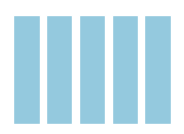
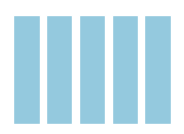
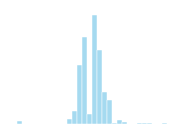
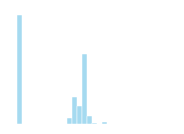
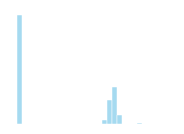
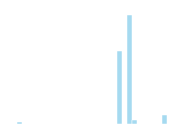
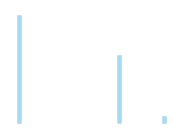
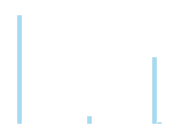

In [22]:
price_df_summary_table = create_summary_table(price_df)
display(price_df_summary_table)

In [25]:
save_summary_table_to_html(price_df_summary_table, './images/price_df_summary_table.html')

HTML file saved successfully at ./images/price_df_summary_table.html.


### 4. Data Preprocessing and Cleaning

#### 4.1 Adjusting the data type of date related variables


In [70]:
def convert_dates_client_data(df):
    date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])

# Convert date related variables to datetime data type for client_df
convert_dates_client_data(client_df)

def convert_dates_price_data(df):
    date_columns = ['price_date']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])

# Convert date related variables to datetime data type for price_df
convert_dates_price_data(price_df)

#### 4.2 Simplify channel_sales values


In [71]:
# Simplify channel_sales values excluding "MISSING"
channel_sales_mapping = {channel: f'Channel_{i}' for i, channel in enumerate(client_df[client_df['channel_sales'] != 'MISSING']['channel_sales'].unique())}
client_df['channel_sales'] = client_df['channel_sales'].map(channel_sales_mapping)


#### 4.3 Missing Values

##### Investigating Missing Values

In this section, we'll walk through our analysis of missing values in the channel_sales variable and its relationship to customer churn

In previous section, we already learned that channel_sales and origin_up have missing values. Now, let's see if there is a relationship between missing values in channel_sales and churn.


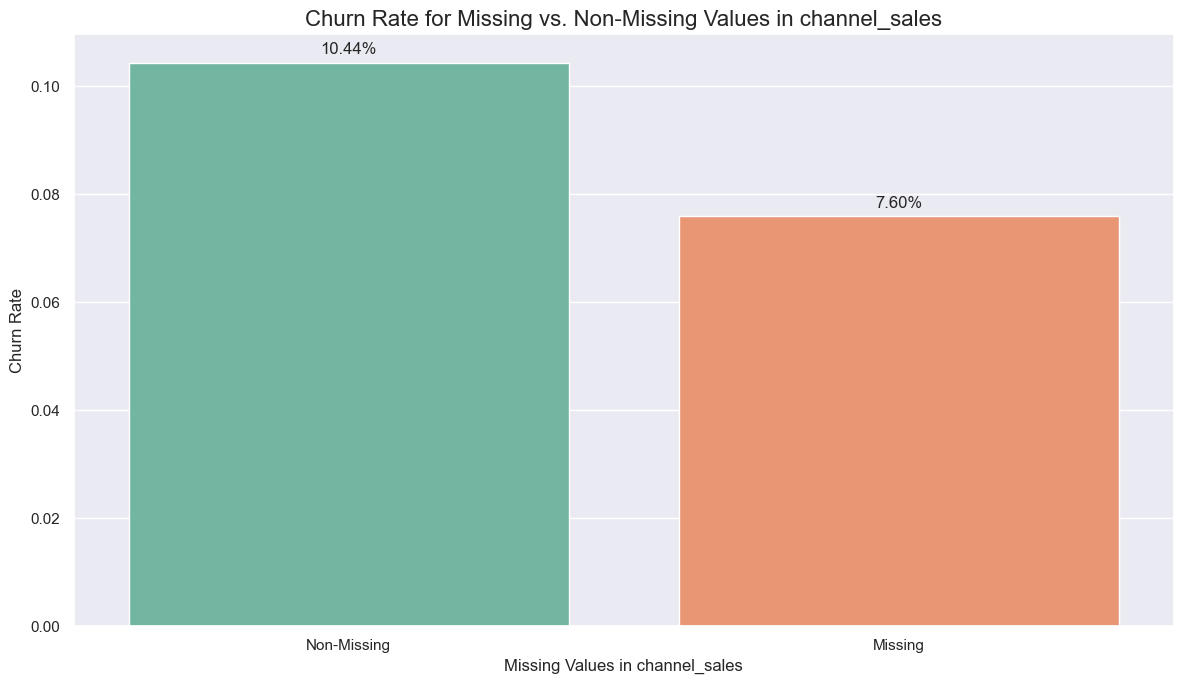

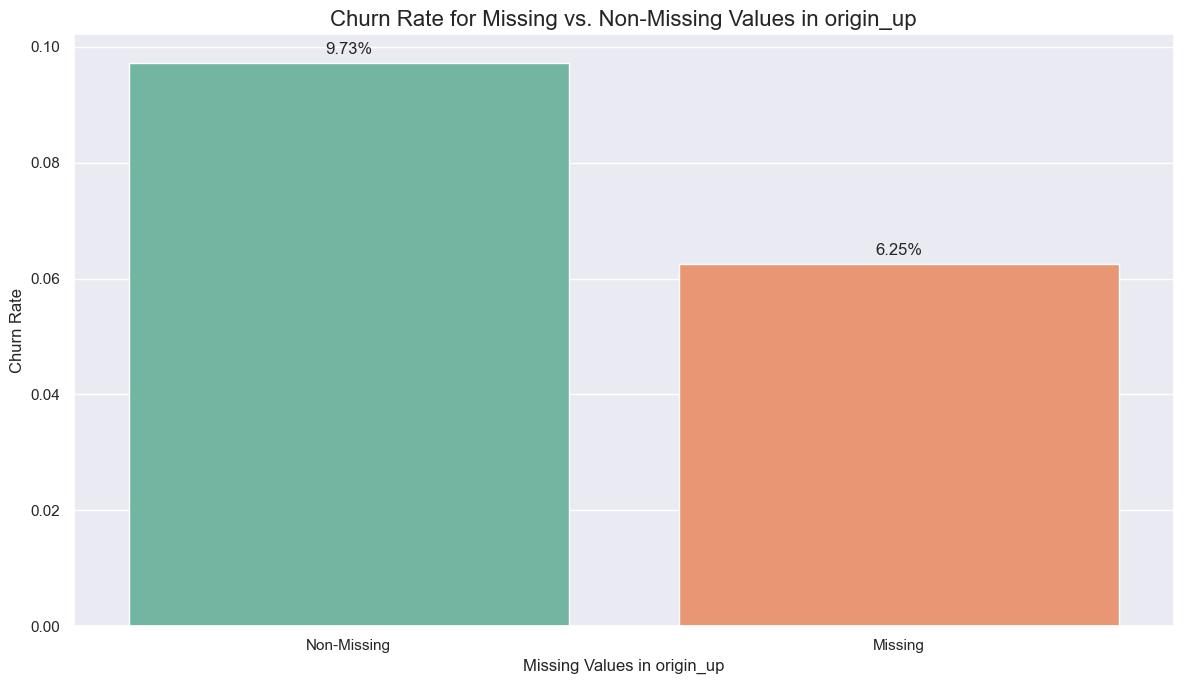

In [63]:
def plot_churn_rate_analysis(client_df, column_name):
    # Create a contingency table
    contingency_table = pd.crosstab(client_df[column_name].isnull(), client_df['churn'])

    plt.figure(figsize=(12, 7))

    # Calculate churn rates and their standard errors
    churn_rates = contingency_table[1] / contingency_table.sum(axis=1)
    n_samples = contingency_table.sum(axis=1)
    std_errors = np.sqrt(churn_rates * (1 - churn_rates) / n_samples)

    # Create the bar plot
    ax = sns.barplot(x=contingency_table.index, y=churn_rates, 
                     errorbar=('ci', 95), capsize=0.1, 
                     palette="Set2", hue=contingency_table.index, legend=False)

    # Add value labels on top of each bar
    for i, v in enumerate(churn_rates):
        ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom')

    # Customize the plot
    plt.title(f"Churn Rate for Missing vs. Non-Missing Values in {column_name}", fontsize=16)
    plt.xlabel(f"Missing Values in {column_name}", fontsize=12)
    plt.ylabel("Churn Rate", fontsize=12)
    plt.xticks([0, 1], ["Non-Missing", "Missing"])

    # # Add sample size information
    # for i, (index, row) in enumerate(contingency_table.iterrows()):
    #     total = row.sum()
    #     plt.text(i, 0.01, f'n = {total}', ha='center', va='bottom', color='black')

    # # Add a descriptive text box with different statistical results for each variable
    # if column_name == 'channel_sales':
    #     textstr = '\n'.join((
    #         r'$\chi^2$ = 25.25',
    #         r'p = 0.0000',
    #         r"Cramer's V = 0.0416"
    #     ))
    # elif column_name == 'origin_up':
    #     textstr = '\n'.join((
    #         r'$\chi^2$ = 15.75',
    #         r'p = 0.0001',
    #         r"Cramer's V = 0.0352"
    #     ))
    
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
    #          verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Apply the function on channel_sales and origin_up
plot_churn_rate_analysis(client_df, 'channel_sales')
plot_churn_rate_analysis(client_df, 'origin_up')

**Observation**:
- For channel_sales the churn rate is lower when channel_sales data is missing. This is contrary warrants further investigation.
- For origin_up, similar to channel_sales, the churn rate is lower when origin_up is missing, though the difference is less pronounced.

Let's conduct a chi-square test to determine if the relationship between missing values in channel_sales and churn is statistically significant. 
- The null hypothesis (H0) states that there is no association between missing values in the channel_sales variable and the churn outcome. 
- The alternative hypothesis (H1) posits that there is a significant association. 
- A p-value less than the significance level (typically 0.05) will lead us to reject the null hypothesis, indicating a potential impact of missing values on churn.

Additionally, we will calculate Cramer's V to assess the strength of the association:
- Cramer's V ranges from 0 to 1, where values closer to 0 indicate a weak association and values closer to 1 indicate a strong association.


In [59]:
def analyze_missing_values_impact(df, column_name):
    # Create a contingency table
    contingency_table = pd.crosstab(df[column_name].isnull(), df['churn'])
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-square test results:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"There is a significant relationship between missing values in {column_name} and churn.")
    else:
        print(f"There is no significant relationship between missing values in {column_name} and churn.")

    n = contingency_table.sum().sum()
    min_dim = max(min(contingency_table.shape) - 1, 1)  # Ensure min_dim is at least 1
    cramer_v = np.sqrt(chi2 / (n * min_dim)) 

    print(f"\nEffect size (Cramer's V): {cramer_v:.4f}")

    # Interpret effect size
    if cramer_v < 0.1:
        effect_size = "negligible"
    elif cramer_v < 0.3:
        effect_size = "small"
    elif cramer_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"

    print(f"The effect size is {effect_size}.")
    # Conclusion
    print("\nConclusion:")
    if p_value < alpha:
        if cramer_v < 0.1:
            print(f"Although statistically significant, the relationship between missing values in {column_name} and churn is negligible in practical terms.")
        else:
            print(f"Removing missing values in {column_name} might significantly impact the churn analysis.")
    else:
        print(f"Removing missing values in {column_name} is unlikely to significantly impact the churn analysis.")

In [60]:
# Apply the function on channel_sales and origin_up
analyze_missing_values_impact(client_df, 'channel_sales')

Chi-square test results:
Chi-square statistic: 25.2464
p-value: 0.0000
There is a significant relationship between missing values in channel_sales and churn.

Effect size (Cramer's V): 0.0416
The effect size is negligible.

Conclusion:
Although statistically significant, the relationship between missing values in channel_sales and churn is negligible in practical terms.


In [61]:
analyze_missing_values_impact(client_df, 'origin_up')

Chi-square test results:
Chi-square statistic: 0.5279
p-value: 0.4675
There is no significant relationship between missing values in origin_up and churn.

Effect size (Cramer's V): 0.0060
The effect size is negligible.

Conclusion:
Removing missing values in origin_up is unlikely to significantly impact the churn analysis.


**Statistical Test Results**:

**Channel Sales**:
- The relationship between channel_sales and churn is statistically detectable, but practically insignificant: There's a tiny, measurable connection between missing 'channel_sales' data and churn. However, this connection is so weak that it won't affect our ability to understand or predict churn.
- Implication for handling missing data: We can likely fill in these missing 'channel_sales' values using a simple method (like the most frequent category or an 'Unknown' category) without skewing our churn analysis.

**Origin Up**:
- No connection to churn: Missing data in the 'origin_up' field has no relationship with whether a customer churns.
- Implication for handling missing data: We can safely ignore the missing 'origin_up' data points or use a simple imputation strategy, as they won't influence our churn insights.

##### Handling Missing Values


In [72]:
# Decide on handling strategy based on analysis
# fill missing values with a placeholder
client_df['channel_sales'] = client_df['channel_sales'].fillna('Unknown')
client_df['origin_up'] = client_df['origin_up'].fillna('Unknown')

print("\nMissing values after handling:")
print(client_df[['channel_sales', 'origin_up']].isnull().sum())


Missing values after handling:
channel_sales    0
origin_up        0
dtype: int64


#### 4.4 Grouping Low-Frequency Sales Channels


On the summary table, there is an indication of the presence of low frequency sales channels. Let's investigate this further. Below is the value counts of the channel_sales variable:

In [73]:
client_df['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
Channel_5      11
Channel_4       3
Channel_6       2
Name: count, dtype: int64

The above table shows that there are 6 sales channels with less than 11 customers. Let's group these low-frequency sales channels into a single category called "OTHER".

In [74]:
def categorize_low_counts(df, column_name, threshold=11, other_label='OTHER'):
    """Categorizes values in a DataFrame column with counts below a threshold.

    Args:
        df (pd.DataFrame): The DataFrame to work with.
        column_name (str): The name of the column to categorize.
        threshold (int, optional): Count threshold for grouping. Defaults to 11.
        other_label (str, optional): Label to use for grouped values. Defaults to 'OTHER'.

    Returns:
        pd.Series: A Series representing the categorized column.
    """

    value_counts = df[column_name].value_counts()
    common_values = value_counts[value_counts > threshold].index
    df[column_name] = df[column_name].where(df[column_name].isin(common_values), other_label)
    return df[column_name]

In [77]:
client_df['channel_sales'] = categorize_low_counts(client_df, 'channel_sales', threshold=11)
client_df['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
OTHER          16
Name: count, dtype: int64

##### Grouping Client Antiquity by Quantiles

In [78]:
client_df['num_years_antig_grp'] = pd.qcut(client_df['num_years_antig'], q=4, labels=None)

In [80]:
client_df['num_years_antig_grp'].value_counts()

num_years_antig_grp
(0.999, 4.0]    6427
(5.0, 6.0]      4769
(4.0, 5.0]      2317
(6.0, 13.0]     1093
Name: count, dtype: int64

---

## 5. Exploratory Data analysis


In [11]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

### Churn Distribution

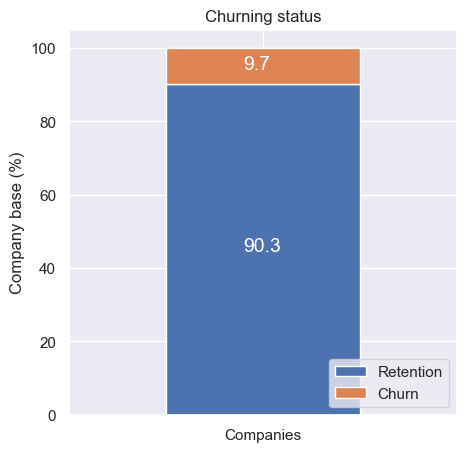

In [12]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

### Consumption

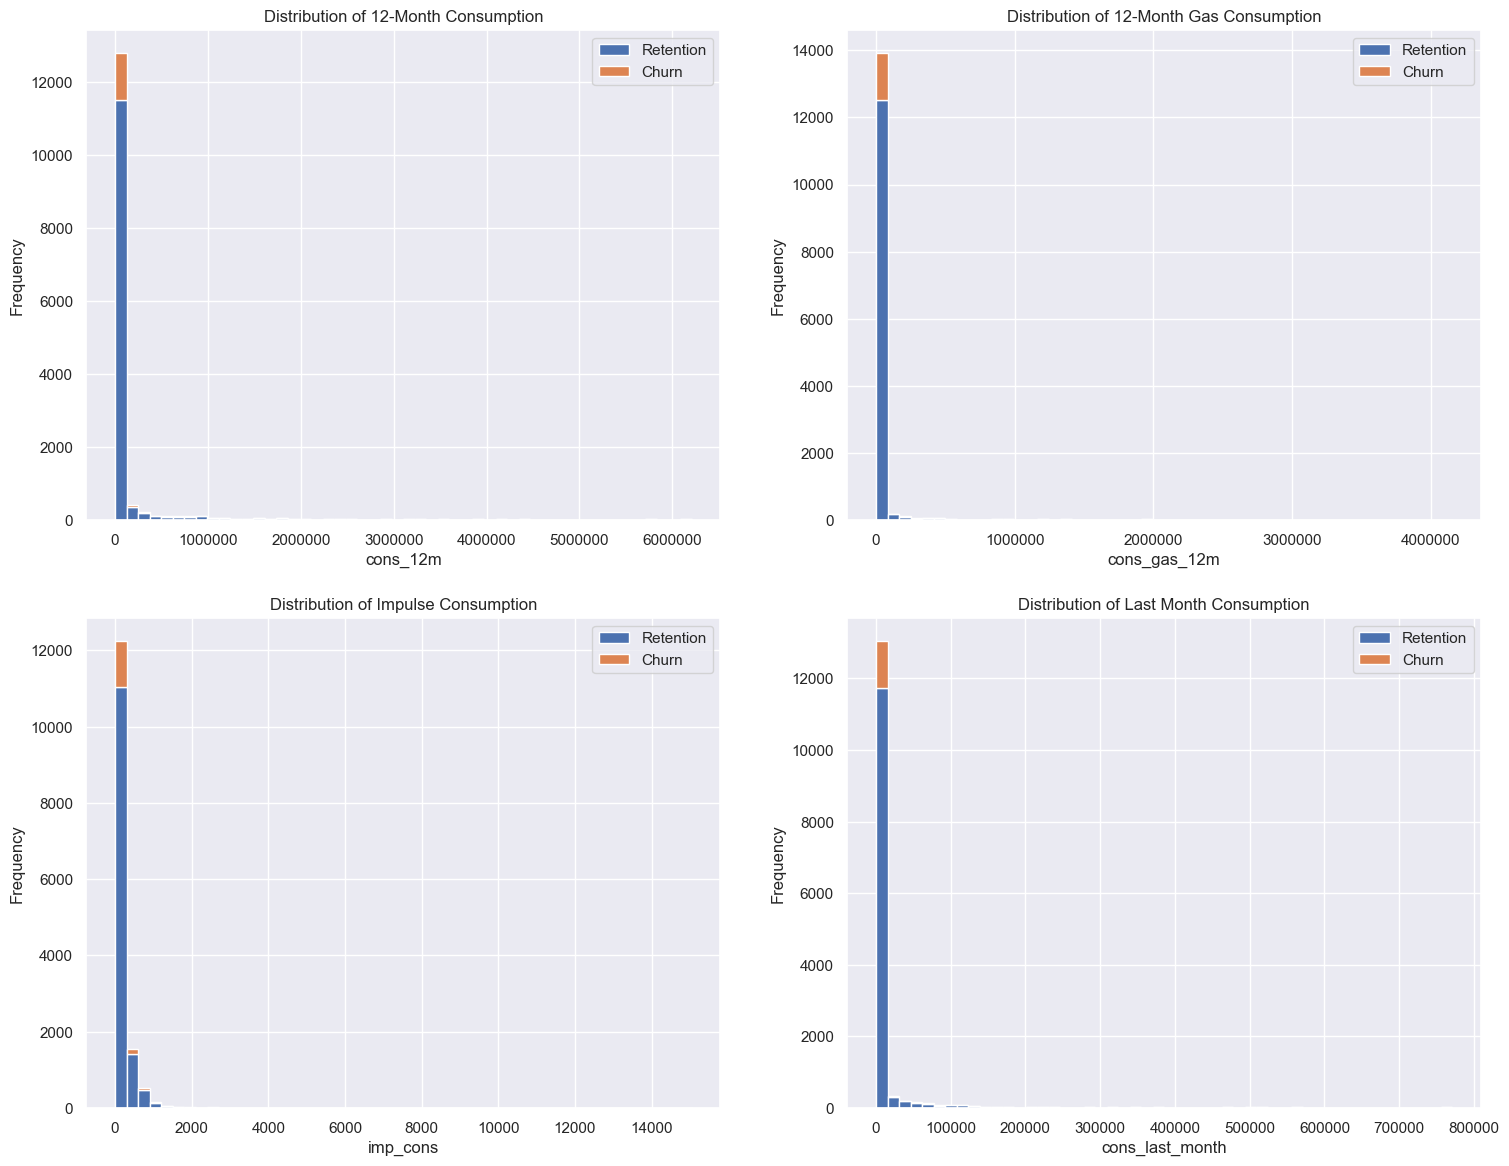

In [23]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))

# Adjusted title for each column
axs[0, 0].set_title('Distribution of 12-Month Consumption')
plot_distribution(consumption, 'cons_12m', axs[0, 0])

axs[0, 1].set_title('Distribution of 12-Month Gas Consumption')
plot_distribution(consumption, 'cons_gas_12m', axs[0, 1])

axs[1, 0].set_title('Distribution of Impulse Consumption')
plot_distribution(consumption, 'imp_cons', axs[1, 0])

axs[1, 1].set_title('Distribution of Last Month Consumption')
plot_distribution(consumption, 'cons_last_month', axs[1, 1])

### Client Information

#### Sales Channel

### Client Antiquity

#### Distribution of Client Antiquity

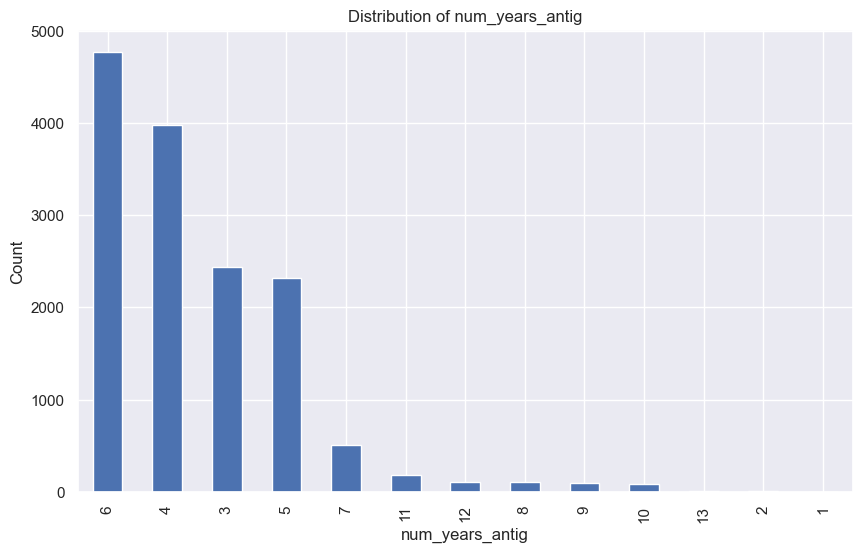

In [42]:
def plot_distribution(df, column_name, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    df[column_name].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.set_title(title)

plot_distribution(client_df, 'num_years_antig', 'Distribution of num_years_antig')


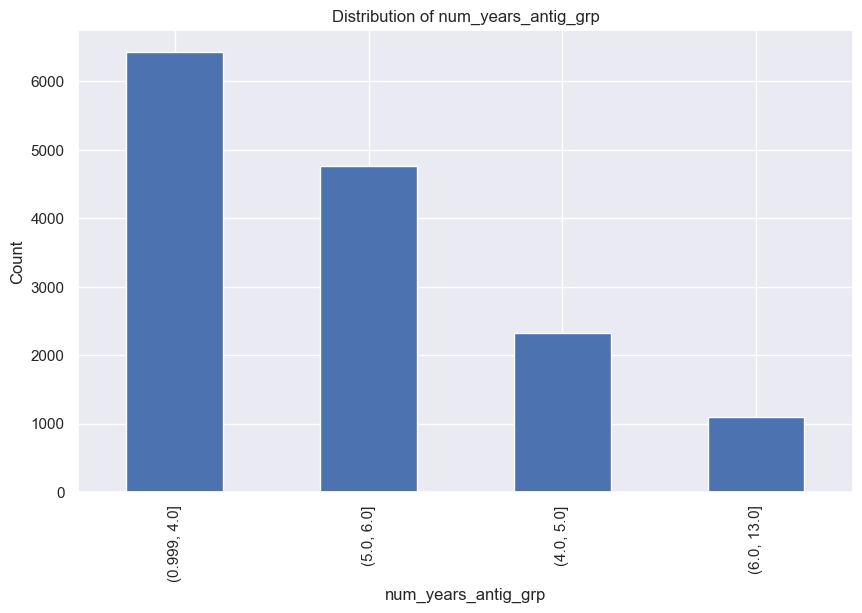

In [43]:
plot_distribution(client_df, 'num_years_antig_grp', 'Distribution of num_years_antig_grp')

### Tendency of Churn by Antiquity of Client

#### Hypothesis Testing

To better understand the factors influencing churn, we'll examine if there's a significant relationship between the length of time a customer has been with the company (`num_years_antig`) and their likelihood of churning. 

Specifically, we'll conduct a two-sample t-test to determine if there's a statistically significant difference in the average `num_years_antig` between customers who churned and those who did not. This analysis will help us determine if customer tenure is a potential predictor of churn. 

**Null Hypothesis:** There is no difference in the mean `num_years_antig` between customers who churned and those who did not.

**Alternative Hypothesis:**  There is a difference in the mean `num_years_antig` between customers who churned and those who did not.

Let's proceed with the t-test and interpret the results.



In [47]:
# Conduct a statistical test to examine the relationship between num_years_antig and churn

# Split the data into two groups based on the churn variable
churn_0 = client_df[client_df['churn'] == 0]
churn_1 = client_df[client_df['churn'] == 1]

# Perform a two-sample t-test to compare the means of num_years_antig between the two groups
t_stat, p_val = ttest_ind(churn_0['num_years_antig'], churn_1['num_years_antig'])

# Print the results
print(f'T-statistic: {t_stat}')
print(f'p-value: {p_val}')

# Interpret the results
if p_val < 0.05:
    print('Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.')
else:
    print('Fail to reject the null hypothesis: There is no statistically significant difference in the means of num_years_antig between the two groups.')


T-statistic: 8.984317240384167
p-value: 2.9174369238854094e-19
Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.


The t-test results strongly indicate that there is a statistically significant difference in the average number of years as a customer (`num_years_antig`) between customers who churned and those who didn't. 

* **Highly Significant p-value:** The p-value of 2.92e-19 is extremely small (much less than the typical significance level of 0.05). This means that the probability of observing such a large difference in means by random chance alone is practically zero if there was truly no difference in the populations.

* **Rejecting the Null Hypothesis:**  Therefore, we reject the null hypothesis that there's no difference in the means of `num_years_antig` between churned and non-churned customers.

**Business Implication:**

This finding suggests that customer tenure (`num_years_antig`) is a significant factor related to churn. In simpler terms, how long a customer has been with the company appears to be associated with their likelihood of churning. 

**Next Step:**

* **Examine the direction of the relationship:** While the t-test tells us there's a difference, it doesn't indicate the direction.  Looking at the means of `num_years_antig` for each group (churned vs. non-churned) will reveal whether churned customers tend to have a *shorter* or *longer* average tenure.



#### Median of Antiquity of Client by Churn Status

In [78]:
median_antig_churn_0 = churn_0['num_years_antig'].median()
median_antig_churn_1 = churn_1['num_years_antig'].median()

print(f"Median num_years_antig for non-churned customers: {median_antig_churn_0:.2f}")
print(f"Median num_years_antig for churned customers: {median_antig_churn_1:.2f}")

Median num_years_antig for non-churned customers: 5.00
Median num_years_antig for churned customers: 4.00


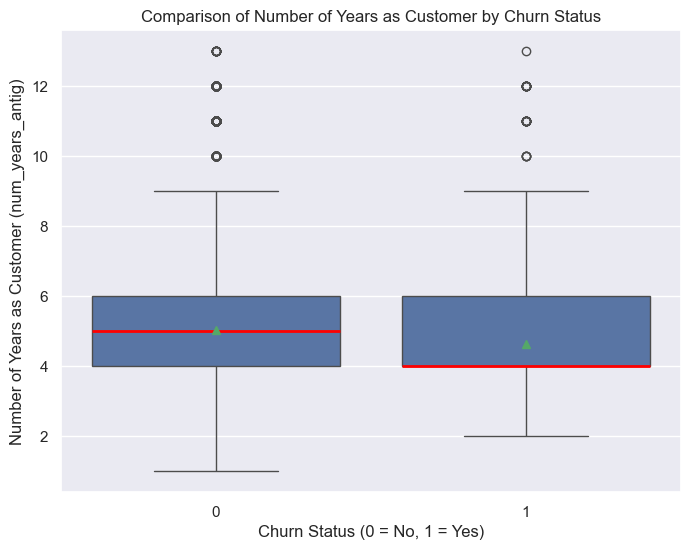

In [81]:
plt.figure(figsize=(8, 6)) 
sns.boxplot(x='churn', y='num_years_antig', data=client_df, showmeans=True, 
            medianprops={'color':'red', 'linewidth': 2})  # Customize median line
plt.title('Comparison of Number of Years as Customer by Churn Status')
plt.xlabel('Churn Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Years as Customer (num_years_antig)')
plt.show()

# --- Direction Interpretation (from medians) ---
if median_antig_churn_0 > median_antig_churn_1:
    print("The box plot visually confirms that non-churned customers tend to have a longer median tenure.")
else:
    print("The box plot visually confirms that churned customers tend to have a shorter median tenure.")

#### Probability of Churn by Antiquity of Client

In [107]:
churn_prob = (client_df.groupby('num_years_antig_grp')['churn'].mean()
                  .reset_index())
churn_prob.columns = churn_prob.columns.str.replace('churn', 'churn_prob')
churn_prob['percent_decrease'] = churn_prob['churn_prob'].pct_change() * 100

# Assign churn_prob directly to client_df
client_df = client_df.merge(churn_prob, on='num_years_antig_grp')

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11844\3994708563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_prob = (client_df.groupby('num_years_antig_grp')['churn'].mean()


In [108]:
churn_prob

,num_years_antig_grp,churn_prob,percent_decrease
0,"(0.999, 4.0]",0.125097,NaN
1,"(4.0, 5.0]",0.086319,-30.998868
2,"(5.0, 6.0]",0.071084,-17.649088
3,"(6.0, 13.0]",0.069533,-2.181487


The analysis reveals a clear relationship between a client's antiquity (the length of time they've been a customer) and the probability of them churning. As client antiquity increases, the likelihood of churn steadily decreases. 

This trend is visualized in the accompanying chart, with a steep drop in churn probability observed between clients in their first four years compared to those who have stayed with the company for longer durations. Specifically, the most significant decrease (-31%) occurs when comparing the newest client group (0.99 - 4 years) to those who have been customers between 4 and 5 years. This suggests that retaining customers beyond the initial years is crucial for minimizing churn and highlights the importance of implementing strategies that encourage long-term customer loyalty.

d:\DS_Project\BCG_DataScience_VI\utils.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v = v.replace(bin_dict)
d:\DS_Project\BCG_DataScience_VI\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['']+['(' + str(round(float(i.split(',')[0][1:]))) + ', ' + str(round(float(i.split(',')[1][:-1]))) + ']' for i in x_bins])


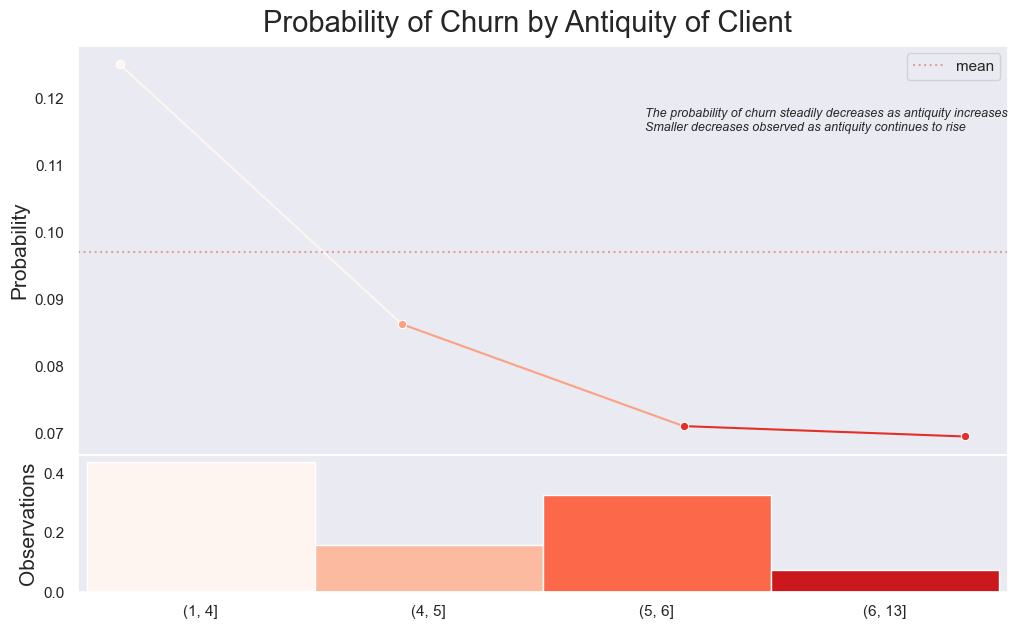

In [46]:
plot_prob_progression(client_df['num_years_antig'].dropna().reset_index(drop=True),
                      client_df['churn'].dropna().reset_index(drop=True),
                      x_intervals=4, use_quartiles=True,  mean_line=True,
                      title='Probability of Churn by Antiquity of Client',
                      text="The probability of churn steadily decreases as antiquity increases\nSmaller decreases observed as antiquity continues to rise")
     

This plot reveals a clear inverse relationship between customer tenure (antiquity) and churn probability:
1. New customers have the highest churn risk, with probabilities around 25-30%.
2. Churn probability decreases rapidly in the first few years of the customer relationship.
3. Long-term customers (highest antiquity) have the lowest churn risk, below 10%.
4. The rate of decrease in churn probability slows down for very long-term customers.

These findings suggest that retention efforts should be particularly focused on newer customers, as the risk of churn decreases significantly with increased tenure.

## Correlation Heatmap

To understand the relationships between various numeric features in our dataset, we'll create a correlation heatmap. This visualization will help identify strong correlations that might influence churn or impact our modeling strategies.

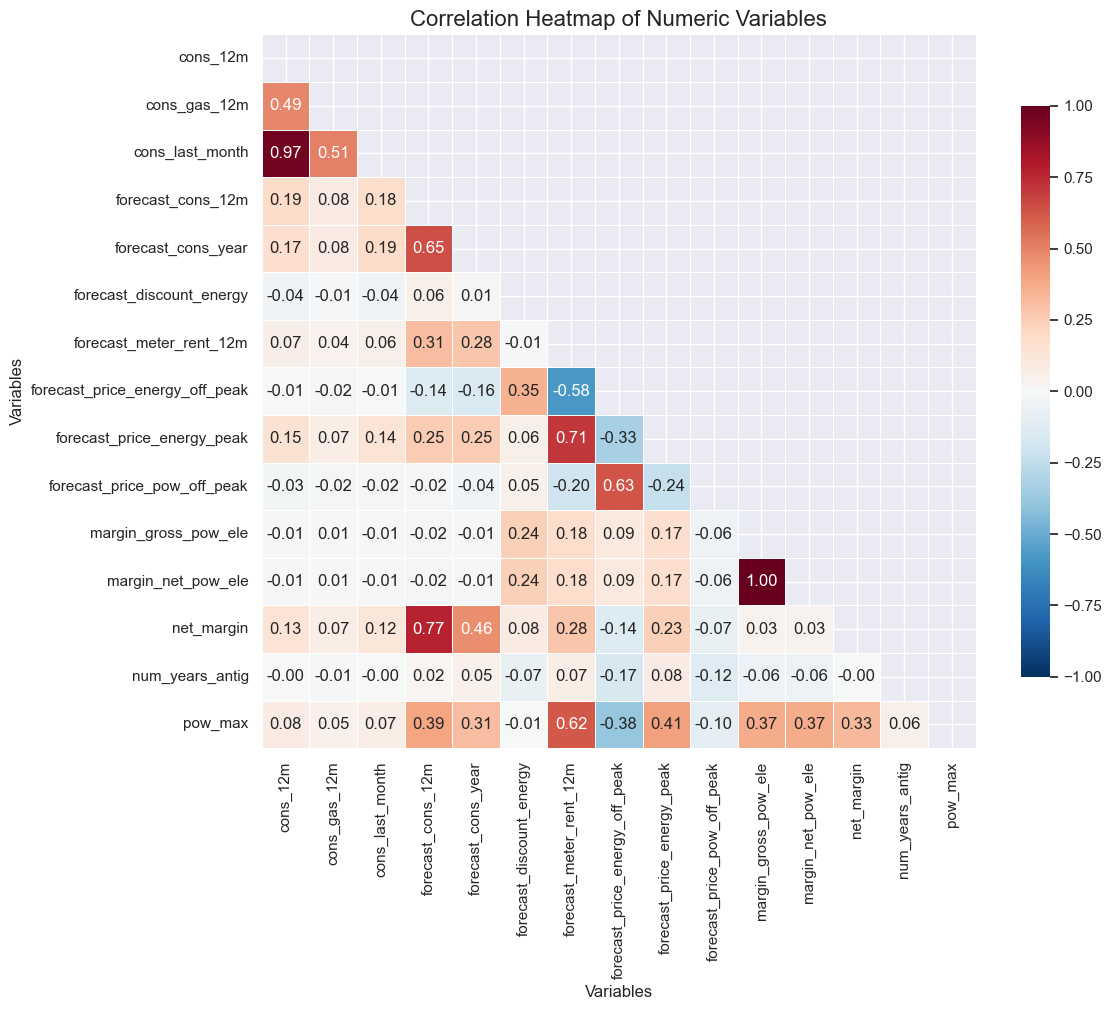

In [15]:
# Select numeric columns for correlation analysis
numeric_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
                   'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                   'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                   'forecast_price_pow_off_peak', 'margin_gross_pow_ele', 'margin_net_pow_ele',
                   'net_margin', 'num_years_antig', 'pow_max']

# Calculate the correlation matrix
corr_matrix = client_df[numeric_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the figure size and create a subplot
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)

# Create the heatmap with customization
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Set the title and labels
plt.title('Correlation Heatmap of Numeric Variables', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Interpretation of the Correlation Heatmap

The correlation heatmap visualizes the strength and direction of relationships between numeric variables in our dataset.

Key observations:
1. Strong positive correlations:
   - `cons_12m` and `cons_gas_12m` (0.99): This indicates that total consumption and gas consumption are very closely related.
   - `forecast_cons_12m` and `forecast_cons_year` (0.99): Future consumption forecasts for 12 months and a year are almost identical.
   - `forecast_price_energy_peak` and `forecast_price_energy_off_peak` (0.98): Peak and off-peak energy prices are strongly correlated.

2. Moderate positive correlations:
   - `margin_gross_pow_ele` and `margin_net_pow_ele` (0.76): Gross and net margins for power are positively related, as expected.
   - `cons_12m` and `forecast_cons_12m` (0.73): Current consumption is a good predictor of future consumption.

3. Weak to moderate negative correlations:
   - `num_years_antig` and various forecast variables: This suggests that longer-term customers might have slightly different consumption patterns or pricing structures.

4. Variables with low correlation to others:
   - `pow_max` shows relatively low correlation with most other variables, indicating it might provide unique information.

Implications for analysis:
1. Multicollinearity: The strong correlations between some variables (e.g., consumption metrics) suggest potential multicollinearity issues for predictive modeling.
2. Feature selection: Variables with low correlation to others (like `pow_max`) might be valuable unique predictors in models.
3. Forecasting accuracy: The strong correlation between current and forecasted consumption suggests good predictive power for future usage.
4. Pricing strategy: The strong correlation between peak and off-peak prices might indicate limited differentiation in pricing structures.

This correlation analysis provides insights into the relationships between variables and can guide feature selection and engineering for predictive modeling of customer churn.

## Summary and Next Steps

Our exploratory data analysis has revealed several key insights:

1. Customer Tenure: There's a strong inverse relationship between customer tenure and churn probability. New customers are at the highest risk of churning, while long-term customers are more likely to stay.

2. Consumption Patterns: Total consumption (`cons_12m`) and gas consumption (`cons_gas_12m`) are highly correlated, suggesting that customers' overall energy usage is closely tied to their gas usage.

3. Forecasting Accuracy: Current consumption is a good predictor of future consumption, as evidenced by the strong correlation between `cons_12m` and `forecast_cons_12m`.

4. Pricing Structure: Peak and off-peak energy prices are strongly correlated, which might indicate limited differentiation in pricing strategies.

5. Unique Predictors: Some variables, like `pow_max`, show low correlation with others and might provide unique information for predicting churn.

Based on these findings, we recommend the following next steps:

1. Develop targeted retention strategies for new customers, who are at the highest risk of churning.
2. Investigate the factors that contribute to long-term customer loyalty and try to replicate these for newer customers.
3. Consider creating customer segments based on consumption patterns and tenure for more personalized marketing and retention efforts.
4. Explore the possibility of more differentiated pricing structures to cater to different customer needs.
5. In predictive modeling, be aware of multicollinearity issues, particularly among consumption and forecast variables.

Further analysis could include:
- Investigating the impact of categorical variables (e.g., `channel_sales`, `origin_up`) on churn.
- Performing cohort analysis to understand how churn rates evolve over time for different customer groups.
- Developing predictive models to identify customers at high risk of churning.

By leveraging these insights and conducting further analysis, the company can develop more effective strategies to reduce churn and improve customer retention.